# Task 2

---

## Predictive modeling of customer bookings

This Jupyter notebook includes some code to get you started with this predictive modeling task. We will use various packages for data manipulation, feature engineering and machine learning.

### Exploratory data analysis

First, we must explore the data in order to better understand what we have and the statistical properties of the dataset.

In [18]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import math
from time import time
from scipy.stats import randint as sp_randint

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import mean_squared_error, r2_score, accuracy_score
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix

from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import RandomOverSampler

In [2]:
df = pd.read_csv("customer_booking.csv", encoding="ISO-8859-1")
df.head()

,num_passengers,sales_channel,trip_type,purchase_lead,length_of_stay,flight_hour,flight_day,route,booking_origin,wants_extra_baggage,wants_preferred_seat,wants_in_flight_meals,flight_duration,booking_complete
0,2,Internet,RoundTrip,262,19,7,Sat,AKLDEL,New Zealand,1,0,0,5.52,0
1,1,Internet,RoundTrip,112,20,3,Sat,AKLDEL,New Zealand,0,0,0,5.52,0
2,2,Internet,RoundTrip,243,22,17,Wed,AKLDEL,India,1,1,0,5.52,0
3,1,Internet,RoundTrip,96,31,4,Sat,AKLDEL,New Zealand,0,0,1,5.52,0
4,2,Internet,RoundTrip,68,22,15,Wed,AKLDEL,India,1,0,1,5.52,0


The `.head()` method allows us to view the first 5 rows in the dataset, this is useful for visual inspection of our columns

In [16]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 14 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   num_passengers         50000 non-null  int64  
 1   sales_channel          50000 non-null  object 
 2   trip_type              50000 non-null  object 
 3   purchase_lead          50000 non-null  int64  
 4   length_of_stay         50000 non-null  int64  
 5   flight_hour            50000 non-null  int64  
 6   flight_day             50000 non-null  int64  
 7   route                  50000 non-null  object 
 8   booking_origin         50000 non-null  object 
 9   wants_extra_baggage    50000 non-null  int64  
 10  wants_preferred_seat   50000 non-null  int64  
 11  wants_in_flight_meals  50000 non-null  int64  
 12  flight_duration        50000 non-null  float64
 13  booking_complete       50000 non-null  int64  
dtypes: float64(1), int64(9), object(4)
memory usage: 5.3+ 

The `.info()` method gives us a data description, telling us the names of the columns, their data types and how many null values we have. Fortunately, we have no null values. It looks like some of these columns should be converted into different data types, e.g. flight_day.

To provide more context, below is a more detailed data description, explaining exactly what each column means:

- `num_passengers` = number of passengers travelling
- `sales_channel` = sales channel booking was made on
- `trip_type` = trip Type (Round Trip, One Way, Circle Trip)
- `purchase_lead` = number of days between travel date and booking date
- `length_of_stay` = number of days spent at destination
- `flight_hour` = hour of flight departure
- `flight_day` = day of week of flight departure
- `route` = origin -> destination flight route
- `booking_origin` = country from where booking was made
- `wants_extra_baggage` = if the customer wanted extra baggage in the booking
- `wants_preferred_seat` = if the customer wanted a preferred seat in the booking
- `wants_in_flight_meals` = if the customer wanted in-flight meals in the booking
- `flight_duration` = total duration of flight (in hours)
- `booking_complete` = flag indicating if the customer completed the booking

Before we compute any statistics on the data, lets do any necessary data conversion

In [4]:
df["flight_day"].unique()

array(['Sat', 'Wed', 'Thu', 'Mon', 'Sun', 'Tue', 'Fri'], dtype=object)

In [4]:
mapping = {
    "Mon": 1,
    "Tue": 2,
    "Wed": 3,
    "Thu": 4,
    "Fri": 5,
    "Sat": 6,
    "Sun": 7,
}

df["flight_day"] = df["flight_day"].map(mapping)

In [5]:
df["flight_day"].unique()

array([6, 3, 4, 1, 7, 2, 5], dtype=int64)

In [6]:
df.describe()

,num_passengers,purchase_lead,length_of_stay,flight_hour,flight_day,wants_extra_baggage,wants_preferred_seat,wants_in_flight_meals,flight_duration,booking_complete
count,50000.000000,50000.000000,50000.00000,50000.00000,50000.000000,50000.000000,50000.000000,50000.000000,50000.000000,50000.000000
mean,1.591240,84.940480,23.04456,9.06634,3.814420,0.668780,0.296960,0.427140,7.277561,0.149560
std,1.020165,90.451378,33.88767,5.41266,1.992792,0.470657,0.456923,0.494668,1.496863,0.356643
min,1.000000,0.000000,0.00000,0.00000,1.000000,0.000000,0.000000,0.000000,4.670000,0.000000
25%,1.000000,21.000000,5.00000,5.00000,2.000000,0.000000,0.000000,0.000000,5.620000,0.000000
50%,1.000000,51.000000,17.00000,9.00000,4.000000,1.000000,0.000000,0.000000,7.570000,0.000000
75%,2.000000,115.000000,28.00000,13.00000,5.000000,1.000000,1.000000,1.000000,8.830000,0.000000
max,9.000000,867.000000,778.00000,23.00000,7.000000,1.000000,1.000000,1.000000,9.500000,1.000000


The `.describe()` method gives us a summary of descriptive statistics over the entire dataset (only works for numeric columns). This gives us a quick overview of a few things such as the mean, min, max and overall distribution of each column.

From this point, you should continue exploring the dataset with some visualisations and other metrics that you think may be useful. Then, you should prepare your dataset for predictive modelling. Finally, you should train your machine learning model, evaluate it with performance metrics and output visualisations for the contributing variables. All of this analysis should be summarised in your single slide.

In [7]:
df['sales_channel'].unique()

array(['Internet', 'Mobile'], dtype=object)

<Axes: xlabel='sales_channel', ylabel='count'>

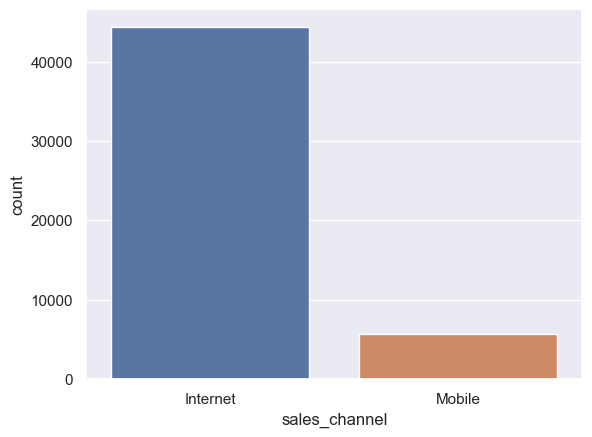

In [12]:
import seaborn as sns
sns.set(style="darkgrid")
sns.countplot(df, x="sales_channel")

<Axes: xlabel='flight_hour', ylabel='count'>

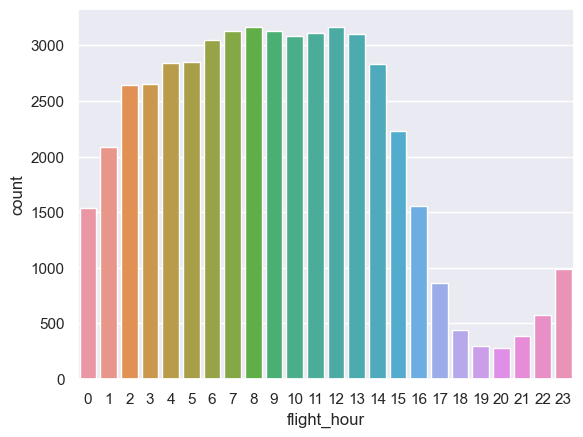

In [13]:
sns.countplot(df, x="flight_hour")

<Axes: xlabel='wants_extra_baggage', ylabel='count'>

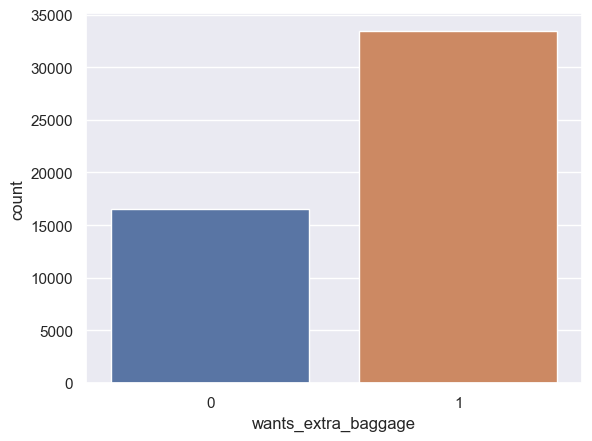

In [17]:
sns.countplot(df, x="wants_extra_baggage")

In [22]:
df['purchase_lead'].value_counts()

1      685
2      670
6      653
7      638
5      615
      ... 
641      1
471      1
614      1
463      1
867      1
Name: purchase_lead, Length: 470, dtype: int64

<Axes: xlabel='purchase_lead', ylabel='count'>

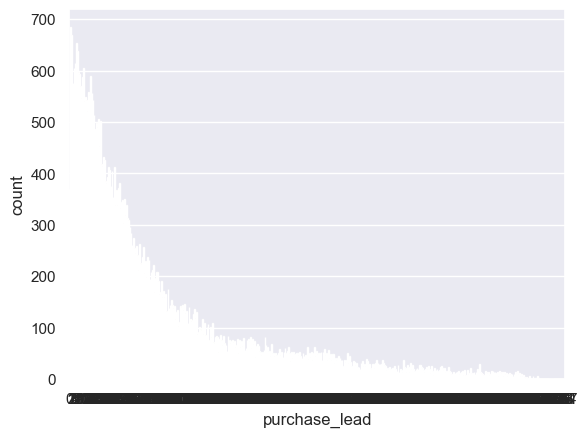

In [21]:
sns.countplot(df, x="purchase_lead")

In [19]:
def run_model(data, output_feature, exclude_features, model_type, imbal_type=None):
    try:
        
        print(data[output_feature].value_counts())
        
        # get input features
        input_features = [item for item in data.columns if item not in [output_feature] + exclude_features]
        
        # split the datasets
        df_train, df_test = train_test_split(data[[output_feature]+input_features].copy(), test_size=0.2, random_state=8001)
         
        #
        # create model
        #        
        if model_type == 'dtc':
            model = DecisionTreeClassifier()
        elif model_type == 'rfc':
            model = RandomForestClassifier(n_estimators=100, max_depth=4, max_features=4)
        else:
            raise Exception('invalid model type')
         
        #
        # imbalance
        #
        if imbal_type == 'under':            
            rus = RandomUnderSampler(random_state=8001)
            X, y = rus.fit_sample(X=df_train[input_features], y=df_train[output_feature].ravel())
        elif imbal_type == 'over':
            ros = RandomOverSampler(random_state=8001)
            X, y = ros.fit_sample(X=df_train[input_features], y=df_train[output_feature].ravel())
        else:
            X = df_train[input_features]
            y = df_train[output_feature].ravel()
            
        print(np.unique(y, return_counts=True))
        
        # train the model
        model.fit(X=X, y=y)
        
        # make predictions
        y_true = df_test[output_feature].ravel()
        y_pred = model.predict(X=df_test[input_features])

        # model accuracy
        acc = accuracy_score(y_pred=y_pred, y_true=y_true)

        print(f'Model: {model_type.upper()} Accuracy for {output_feature} = {acc:.2f}')
        
        return (input_features, model, y_true, y_pred)
    
    except Exception as ex:
        print(ex)

In [37]:
input_features4, model4b, y4b_true, y4b_pred = run_model(data=df, output_feature='num_passengers', exclude_features=['booking_origin','sales_channel','trip_type','flight_day','route'], model_type='rfc', imbal_type=None)

1    31352
2    12804
3     2941
4     1784
5      561
6      289
7      114
8       89
9       66
Name: num_passengers, dtype: int64
(array([1, 2, 3, 4, 5, 6, 7, 8, 9], dtype=int64), array([25118, 10193,  2375,  1428,   439,   228,    92,    73,    54],
      dtype=int64))
Model: RFC Accuracy for num_passengers = 0.64


In [38]:
model4b

RandomForestClassifier(max_depth=4, max_features=4)

In [39]:
model4b.feature_importances_

array([4.64784630e-01, 2.91354488e-01, 1.65686471e-03, 1.68605606e-01,
       1.84589604e-02, 1.86588409e-03, 5.28669719e-02, 4.06595412e-04])

In [40]:
df_features4 = pd.DataFrame(model4b.feature_importances_.flatten(), input_features4, columns=['weights']).reset_index().rename(columns={'index':'feature4'})
df_features4.sort_values(by=['weights'], ascending=False, inplace=True)
df_features4

,feature4,weights
0,purchase_lead,0.464785
1,length_of_stay,0.291354
3,wants_extra_baggage,0.168606
6,flight_duration,0.052867
4,wants_preferred_seat,0.018459
5,wants_in_flight_meals,0.001866
2,flight_hour,0.001657
7,booking_complete,0.000407


In [44]:
from sklearn.tree import export_graphviz
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV

In [34]:
tree = model4b.estimators_[0]

In [36]:
print(export_graphviz(tree, out_file=None, feature_names=input_features4, rounded=True, precision=2))

digraph Tree {
node [shape=box, style="rounded", color="black", fontname="helvetica"] ;
edge [fontname="helvetica"] ;
0 [label="length_of_stay <= 3.5\ngini = 0.99\nsamples = 25291\nvalue = [309, 583, 534, 456, 454, 462, 554, 509, 472, 471\n512, 441, 499, 490, 415, 449, 423, 407, 490, 432\n484, 425, 424, 414, 368, 406, 397, 401, 346, 335\n356, 312, 345, 360, 331, 329, 319, 353, 323, 301\n316, 275, 376, 272, 315, 281, 302, 329, 269, 280\n265, 246, 272, 213, 271, 238, 233, 215, 218, 211\n198, 210, 169, 199, 192, 167, 204, 189, 175, 188\n206, 178, 175, 179, 206, 164, 115, 191, 175, 177\n137, 156, 185, 176, 157, 128, 135, 137, 123, 133\n128, 121, 109, 128, 92, 125, 133, 105, 91, 116, 92\n115, 112, 76, 90, 124, 126, 110, 118, 98, 103, 103\n72, 110, 94, 110, 85, 106, 107, 99, 95, 73, 70\n86, 72, 58, 101, 78, 106, 87, 83, 71, 68, 84, 73\n82, 49, 77, 63, 68, 58, 33, 50, 78, 56, 55, 50\n49, 45, 66, 61, 66, 72, 50, 64, 75, 47, 46, 42\n64, 47, 54, 67, 58, 52, 59, 47, 38, 78, 72, 52\n53, 46, 59, 74

In [42]:
output_feature = 'num_passengers'
exclude_features = ['booking_origin','sales_channel','trip_type','flight_day','route']
# get input features
input_features = [item for item in df.columns if item not in [output_feature] + exclude_features]

# split the datasets
df_train, df_test = train_test_split(df[[output_feature]+input_features].copy(), test_size=0.2, random_state=8001)

In [45]:
rfc_param_dist = {'n_estimators': [20,50,10,200],
                  'max_depth': [2,4,8,None],
                  'max_features': ['auto','sqrt'],
                  'bootstrap': [True, False],
                  'criterion': ["gini", "entropy"]}

# random forest model
rfc = RandomForestClassifier()

In [ ]:
# grid search
rfc_search_grid = GridSearchCV(estimator=rfc, param_grid=rfc_param_dist, cv=5, verbose=2, n_jobs=-1)

# start timer
start = time()

# fit the grid search model
rfc_search_grid.fit(df_train[input_features], df_train[output_feature].ravel())

print('GridSearchCV took {0:.2f} seconds'.format((time() - start)))

Fitting 5 folds for each of 128 candidates, totalling 640 fits


In [ ]:
rfc_search_grid.best_params_

In [ ]:
rfc_search_grid.best_score_

In [ ]:
# random search
rfc_search_random = RandomizedSearchCV(estimator=rfc, param_distributions=rfc_param_dist, n_iter=20, cv=5, verbose=2, n_jobs=-1, random_state=8001)

# start timer
start = time()

# fit the grid search model
rfc_search_random.fit(df_train[input_features], df_train[output_feature].ravel())

print('RadmomSearchCV took {0:.2f} seconds'.format((time() - start)))

In [ ]:
rfc_search_random.best_params_

In [ ]:
rfc_search_random.best_score_

In [ ]:
grid_model = rfc_search_grid.best_estimator_
grid_y_pred = grid_model.predict(X=df_test[input_features])
grid_acc = accuracy_score(y_pred=grid_y_pred, y_true=df_test[output_feature])

print('Grid RF: {0:.3}'.format(grid_acc))
print(classification_report(y_true=df_test[output_feature], y_pred=grid_y_pred))

In [ ]:
rand_model = rfc_search_random.best_estimator_
rand_y_pred = rand_model.predict(X=df_test[input_features])
rand_acc = accuracy_score(y_pred=rand_y_pred, y_true=df_test[output_feature])

print('Random RF: {0:.3}'.format(rand_acc))
print(classification_report(y_true=df_test[output_feature], y_pred=rand_y_pred))